In [ ]:
import numpy as np
import cv2
from collections import defaultdict
import os
import imutils
import sys
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import HTML

Saving prew.jpg to prew.jpg


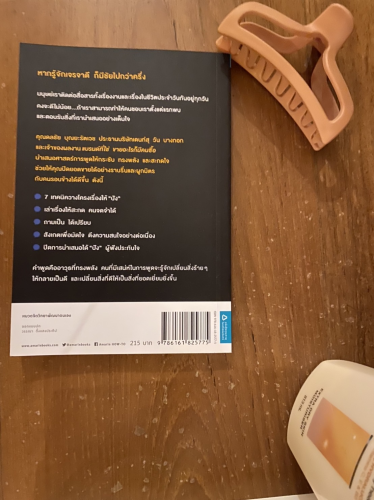

In [ ]:
#@markdown <h3> 🖼️ เลือกรูปภาพ Choose An Image</h3>
#@markdown <small>สามารถเลือกภาพตัวอย่างหรือจะอัพโหลดภาพของคุณ Pick the preset image or upload your own image</small>

image = '\uD83D\uDCE4 upload your image' #@param ['🗏 page', '🧾 receipt', '📤 upload your image']

image = ' '.join(image.split(' ')[1:])
onedrive_dataset = None

image_url = {
  'page': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/EYrbOpH-4KxKh92HODIIu14BtZ-2t7tPW2BAqpK9cpCPwA?download=1',
  'receipt': 'https://tuipied-my.sharepoint.com/:i:/g/personal/sarung_staff_tu_ac_th/Eas6Z4A_v0JBr8r-AEgh8VQBeOoOWC2tdZtEPc_CJ3RPNw?download=1',
}

if image == 'upload your image': onedrive_dataset = ':images_upload:'
elif image in image_url:  onedrive_dataset = image_url[image]
if onedrive_dataset == None: raise Exception('Cannot select image')

preupload_datasets = None
if onedrive_dataset == ':images_upload:':
  display(HTML('<h3>Select your image</h3>'))
  # display(HTML('<p/>You can select multiple images by pressing ctrl, cmd or shift and click.<p>'))
  dir = os.getcwd()
  uploaded = files.upload()
  preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
  image_fn = preupload_datasets[0]
else:
  get_ipython().system_raw('wget -O image.jpg ' + onedrive_dataset)
  image_fn = 'image.jpg'

im = cv2.imread(image_fn)
im = imutils.resize(im,height=500)
cv2_imshow(im)

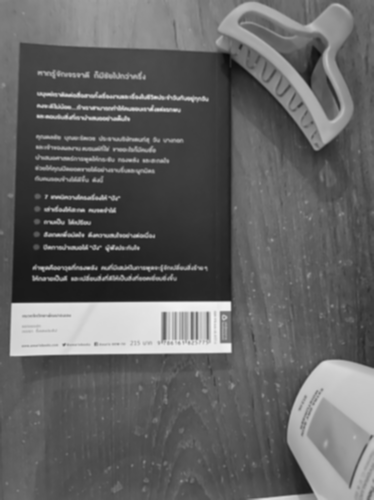

In [ ]:
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
cv2_imshow(gray)

In [ ]:
hsv=cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
lower_white=np.array([0,0,200])
upper_white=np.array([145,111,255])
HSV=cv2.inRange(hsv,lower_white,upper_white)

canny


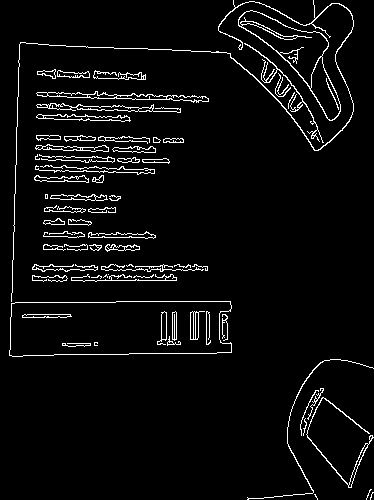

simple_thresh


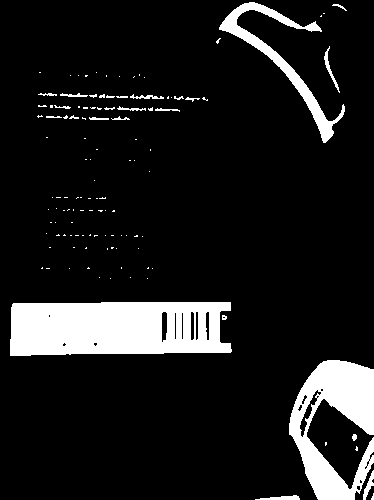

adaptive_thresh


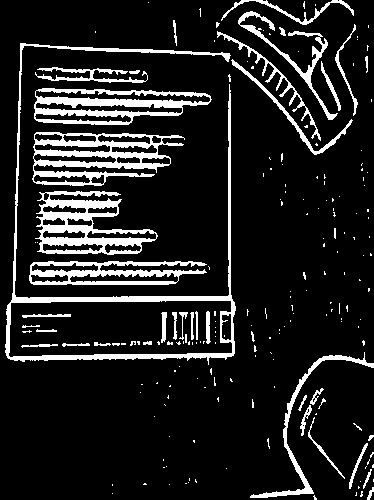

HSV


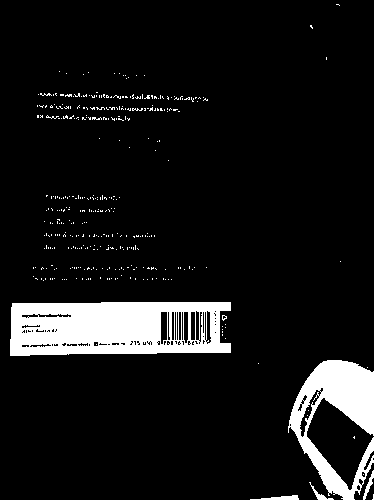

In [ ]:
canny_minval =  10#@param {type:"number"}
canny_maxval =  250#@param {type:"number"}
adaptive_blocksize =  19#@param {type:"number"}
adaptive_C = 10#@param {type:"number"}
canny=cv2.Canny(gray,canny_minval,canny_maxval,)
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, adaptive_blocksize, adaptive_C)
ret, simple_thresh = cv2.threshold(gray,160,255,cv2.THRESH_BINARY)
detect_edged=[canny,simple_thresh,adaptive_thresh,HSV]
detect_edged_name=['canny','simple_thresh','adaptive_thresh','HSV']
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(i)

In [ ]:
def drawContours(im,edged_image):
  orig = im.copy()
  cnts, hierarchy = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:  
    cv2.drawContours(orig, [c], -1, (0, 255, 0), 4)
  return orig

canny


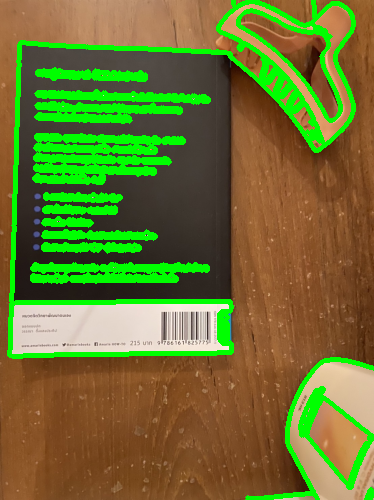

simple_thresh


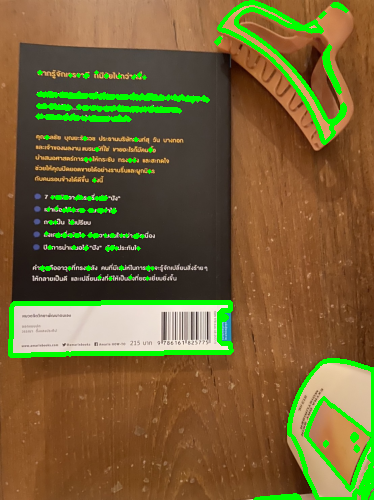

adaptive_thresh


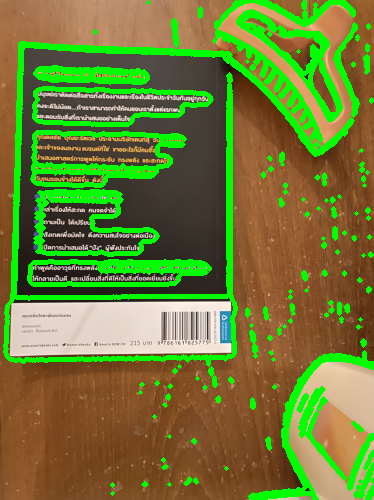

HSV


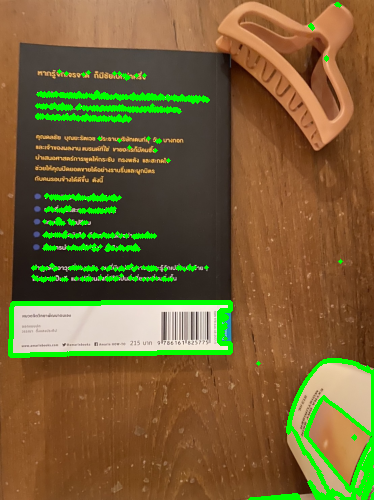

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(drawContours(im,i))  


In [ ]:
def approximate_contour(im,edged_image):
  orig =im.copy()
  cnts, hierarchy = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,0.02*peri,True)
    cv2.drawContours(orig, [approx], -1, (0, 255, 0), 4)
  return orig

canny


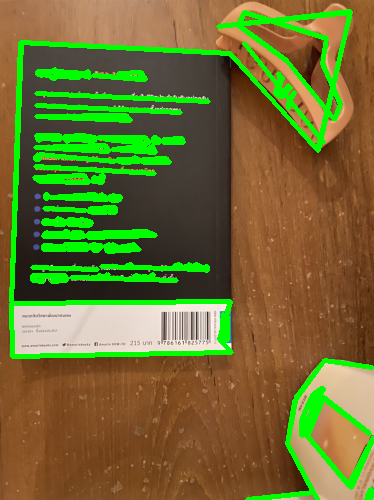

simple_thresh


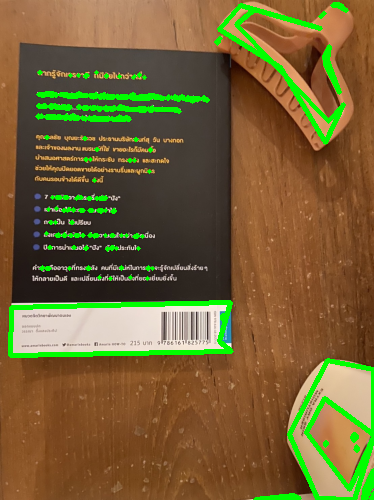

adaptive_thresh


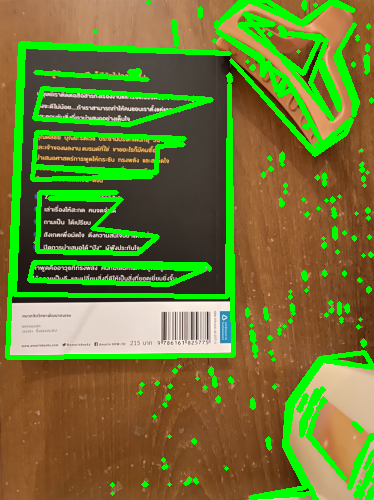

HSV


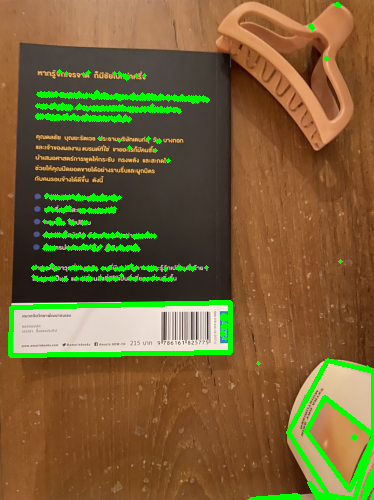

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(approximate_contour(im,i))  


In [ ]:
area = 10000 #@param {type:"slider", min:0, max:50000, step:1}
def approximate_contour_rec(im,edged_image):
  orig =im.copy()
  cnts, hierarchy = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    #hull = cv2.convexHull(c)
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,0.02*peri,True)
    ar = cv2.contourArea(approx)
    if len(approx)==4:
      if ar>area:
        cv2.drawContours(orig, [approx], -1, (0, 255, 0), 4)
  return orig

canny


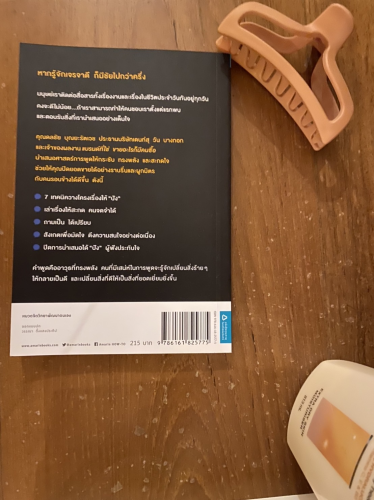

simple_thresh


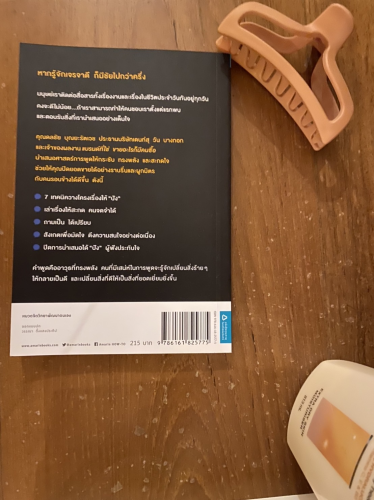

adaptive_thresh


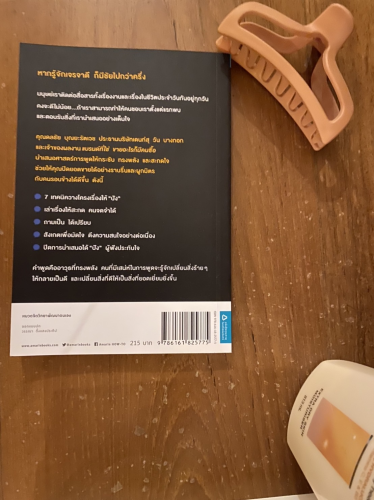

HSV


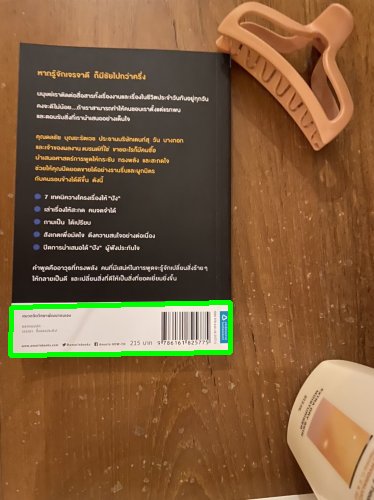

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(approximate_contour_rec(im,i))  


In [ ]:
def fourpoint_contour(im,edged_image):
  cnts, hierarchy = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  screenCnt=[]
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    ar = cv2.contourArea(approx)
    if len(approx) == 4:
      if ar>area:
        screenCnt.append(approx)
  if len(screenCnt)==0:
    return None
  else:
    return screenCnt

In [ ]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest 
	pts_del = np.delete(pts,[np.argmin(s),np.argmax(s)],0)
	diff = np.diff(pts_del, axis = 1)
	rect[1] = pts_del[np.argmin(diff)]
	rect[3] = pts_del[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [ ]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	corner=np.array((tl,tr,br,bl))
	if maxWidth<=maxHeight:
		 a=maxWidth
		 b=maxHeight
	else:
		a=maxHeight
		b=maxWidth
		if tl[1]<tr[1]:
			corner=np.array((bl,tl,tr,br))
		elif tl[1]>tr[1]:
			 corner=np.array((tr,br,bl,tl))	 
	dst = np.array([
		[0, 0],
		[a - 1, 0],
		[a - 1, b - 1],
		[0, b - 1]], dtype = "float32")
	# compute the perspective transformmatrix and then apply 
	M = cv2.getPerspectiveTransform(corner, dst)
	warped = cv2.warpPerspective(image, M, (a, b))

	# return the warped image
	return warped

HSV


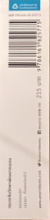

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  if fourpoint_contour(im,i) != None:
    print(j)
    for x in range(len(fourpoint_contour(im,i))):
      warped_contour = four_point_transform(im, fourpoint_contour(im,i)[x].reshape(4,2))
      cv2_imshow(warped_contour)

In [ ]:
harris_thresh=0.1 #@param {type:"slider", min:0, max:1, step:0.1}
def corner_from_harris(im,edged_image):
  dst = cv2.cornerHarris(edged_image,10,15,0.04)
  dot=im.copy()
  dot[dst>0.1*dst.max()]=[0,0,255]
  return dot

canny


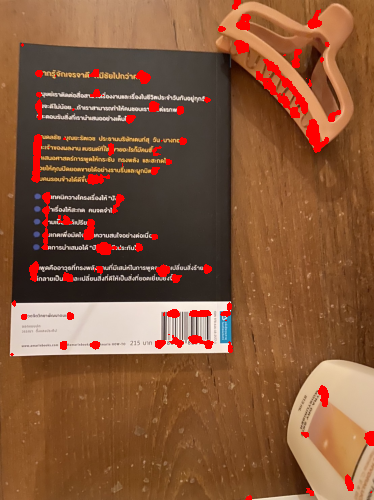

simple_thresh


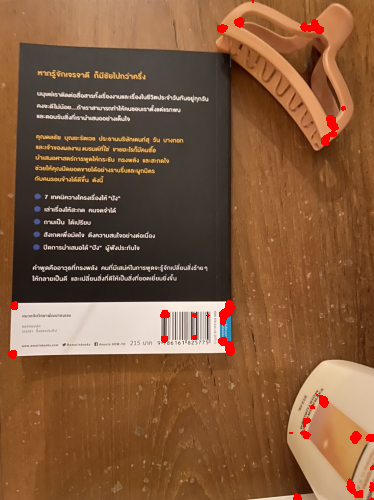

adaptive_thresh


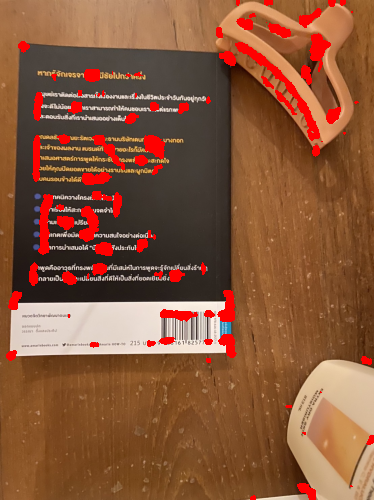

HSV


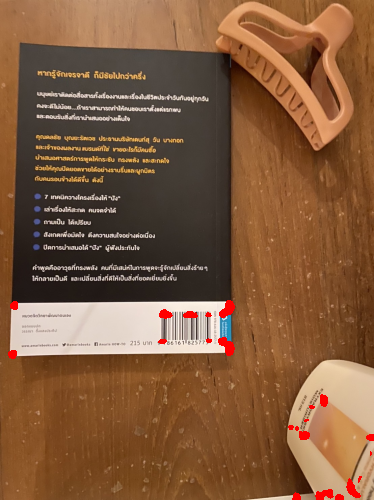

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(corner_from_harris(im,i))  


In [ ]:
def corner_harris(im,edged_image):
  dst = cv2.cornerHarris(edged_image,10,15,0.04)
  mask = dst>0.1*dst.max()
  x, y = mask.nonzero()
  coord = np.array((x, y)).T

# pick the candidate closest to the image corners
  h, w = mask.shape
  tl = np.array((0,0))
  tr = np.array((0,w))
  bl = np.array((h,0))
  br = np.array((h,w))

  corners = []
  for pnt in [tl, tr, br, bl]:
    ((coord - pnt)**2).sum(axis=1).argmin()
    pos = ((coord - pnt)**2).sum(axis=1).argmin()
    corners.append(coord[pos][::-1])
  return corners

In [ ]:
def draw_fourpoint_harris(im,edged_image):
  corners=corner_harris(im,edged_image)
  image = im.copy()
  cv2.polylines(image,[np.array(corners).reshape((-1,1,2))],True,(0,255,255))
  for corner in corners:
    cv2.circle(image, tuple(corner), radius=2, color=(0, 0, 255), thickness=3)
  return image


canny


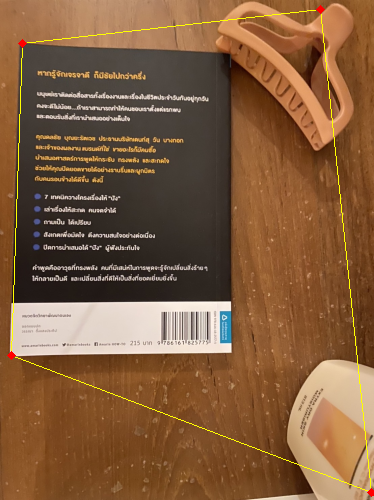

simple_thresh


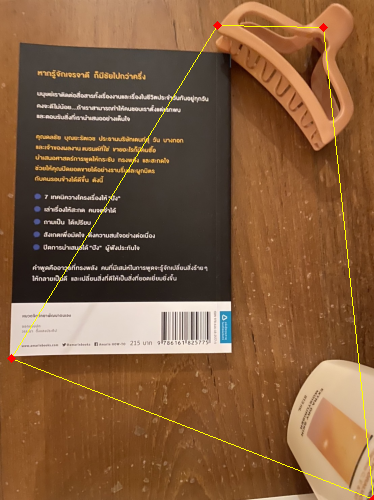

adaptive_thresh


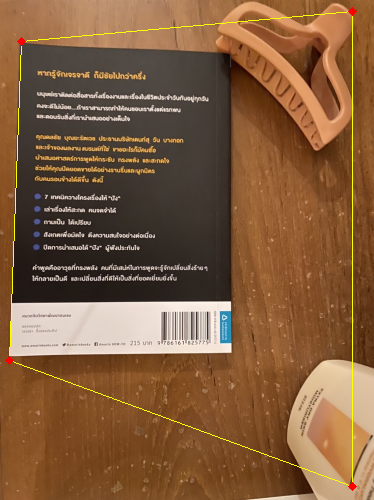

HSV


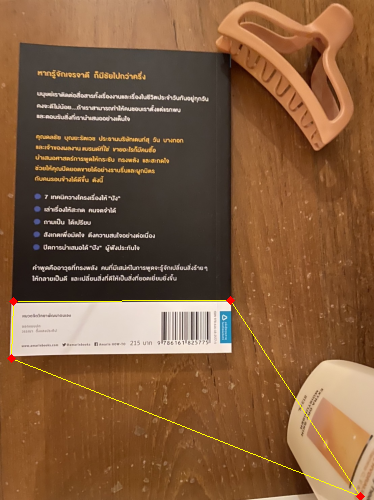

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
  print(j)
  cv2_imshow(draw_fourpoint_harris(im,i))  


canny


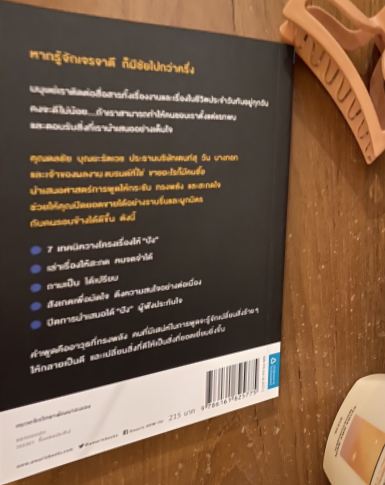

simple_thresh


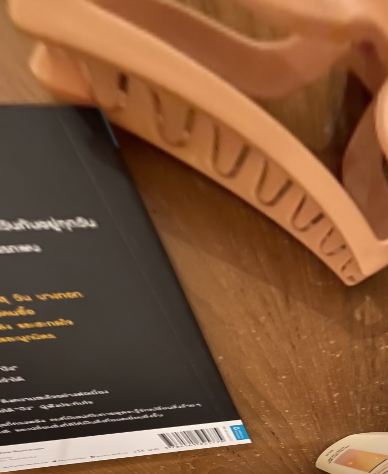

adaptive_thresh


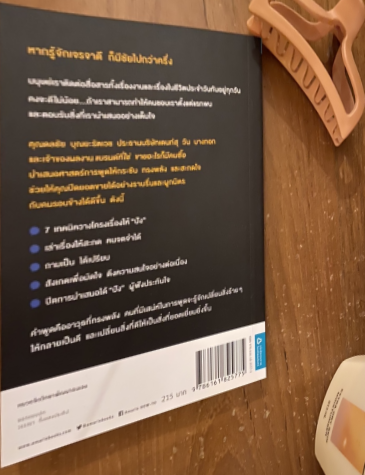

HSV


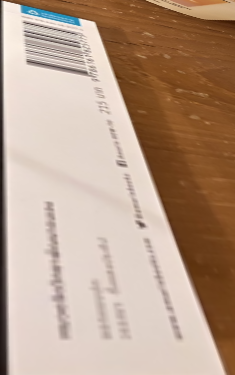

In [ ]:
for (i,j) in zip(detect_edged,detect_edged_name):
    print(j)
    warped_harris = four_point_transform(im, np.array(corner_harris(im,i)))
    cv2_imshow(warped_harris)

In [ ]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """
    Group lines by their angle using k-means clustering.

    Code from here:
    https://stackoverflow.com/a/46572063/1755401
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))

    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # Get angles in [0, pi] radians
    angles = np.array([line[0][1] for line in lines])

    # Multiply the angles by two and find coordinates of that angle on the Unit Circle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)] for angle in angles], dtype=np.float32)

    # Run k-means
    if sys.version_info[0] == 2:
        # python 2.x
        ret, labels, centers = cv2.kmeans(pts, k, criteria, attempts, flags)
    else: 
        # python 3.x, syntax has changed.
        labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]

    labels = labels.reshape(-1) # Transpose to row vector

    # Segment lines based on their label of 0 or 1
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)

    segmented = list(segmented.values())

    return segmented

In [ ]:
def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]


In [ ]:
def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [ ]:
def drawLines(img, lines, color=(0,0,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1,y1), (x2,y2), color, 1)


In [ ]:
def draw_houghlines(im,edged_image,vote):
  lines = cv2.HoughLines(edged_image, 2, np.pi/180, vote)
  if sys.version_info[0] == 2:
      # python 2.x
      temp_lines = []
      N = lines.shape[1]
       # Re-shape from 1xNx2 to Nx1x2
      for i in range(N):
        rho = lines[0,i,0]
        theta = lines[0,i,1]
        temp_lines.append( np.array([[rho,theta]]) )
      lines = temp_lines
  segmented = segment_by_angle_kmeans(lines, 2)
  intersections = segmented_intersections(segmented)

  img_with_segmented_lines = np.copy(im)
  vertical_lines = segmented[1]
  img_with_vertical_lines = np.copy(im)
  drawLines(img_with_segmented_lines, vertical_lines, (0,255,0))

  img_with_segmented_lines = np.copy(im)
  vertical_lines = segmented[1]
  img_with_vertical_lines = np.copy(im)
  drawLines(img_with_segmented_lines, vertical_lines, (0,255,0))

  horizontal_lines = segmented[0]
  img_with_horizontal_lines = np.copy(im)
  drawLines(img_with_segmented_lines, horizontal_lines, (0,255,255))

  for point in intersections:
    pt = (point[0][0], point[0][1])
    length = 5
    cv2.line(img_with_segmented_lines, (pt[0], pt[1]-length), (pt[0], pt[1]+length), (255, 0, 255), 1) # vertical line
    cv2.line(img_with_segmented_lines, (pt[0]-length, pt[1]), (pt[0]+length, pt[1]), (255, 0, 255), 1)

  return img_with_segmented_lines

#cv2_imshow(img_with_segmented_lines)

canny


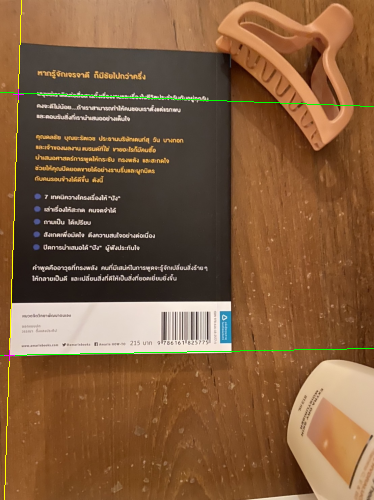

adaptive_thresh


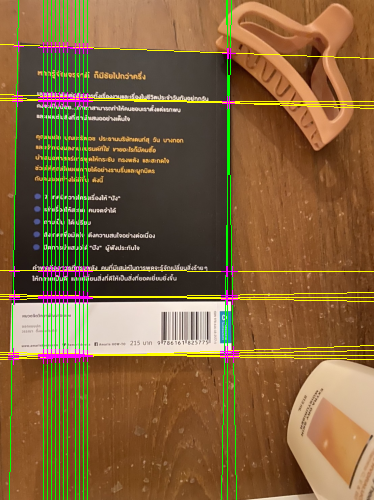

In [ ]:
canny_minimun_vote=192 #@param {type:"slider", min:100, max:500, step:1}
adaptive_thresh_minimun_vote=360 #@param {type:"slider", min:100, max:500, step:1}
detect_edged_houghlines=[canny,adaptive_thresh]
detect_edged_name_houghlines=['canny','adaptive_thresh']
for (i,j) in zip(detect_edged_houghlines,detect_edged_name_houghlines):
  print(j)
  if j == 'canny':
    cv2_imshow(draw_houghlines(im,i,canny_minimun_vote))
  else:
    cv2_imshow(draw_houghlines(im,i,adaptive_thresh_minimun_vote))  


In [ ]:
def intersection_point(im,edged_image,vote):
  lines = cv2.HoughLines(edged_image, 2, np.pi/180, vote)
  if sys.version_info[0] == 2:
      # python 2.x
      temp_lines = []
      N = lines.shape[1]
       # Re-shape from 1xNx2 to Nx1x2
      for i in range(N):
        rho = lines[0,i,0]
        theta = lines[0,i,1]
        temp_lines.append( np.array([[rho,theta]]) )
      lines = temp_lines
  segmented = segment_by_angle_kmeans(lines, 2)
  intersections = segmented_intersections(segmented)
  coord=np.array(intersections).reshape(len(intersections),2)
  coord_point=[]
  for x,y in coord:
    if x>0 and y>0:
      coord_point.append([x,y])
  return coord_point

In [ ]:
def corner_houghlines(im,edged_image,vote):
  point=intersection_point(im,edged_image,vote)
  
  h, w = edged_image.shape
  tl = np.array((0,0))
  tr = np.array((0,w))
  bl = np.array((h,0))
  br = np.array((h,w))
  
  corners = []
  for pnt in [tl, tr, br, bl]:
    ((point - pnt)**2).sum(axis=1).argmin()
    pos = ((point - pnt)**2).sum(axis=1).argmin()
    corners.append(point[pos])
  return corners

In [ ]:
def draw_fourpoint_houghlines(im,edged_image,vote):
  corners = corner_houghlines(im,edged_image,vote)
  image = im.copy()
  cv2.polylines(image,[np.array(corners).reshape((-1,1,2))],True,(0,255,255))
  for corner in corners:
    cv2.circle(image, tuple(corner), radius=2, color=(0, 0, 255), thickness=3)
  return image

canny


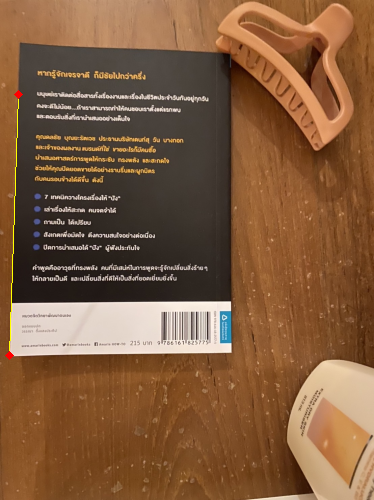

adaptive_thresh


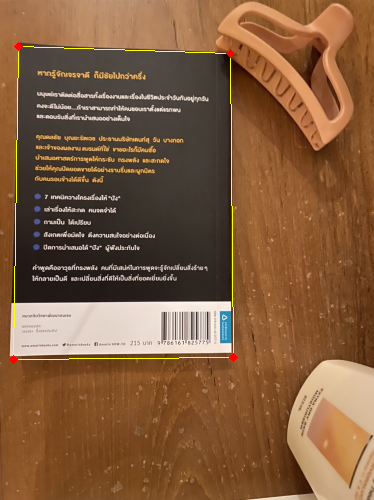

In [ ]:
for (i,j) in zip(detect_edged_houghlines,detect_edged_name_houghlines):
  print(j)
  if j == 'canny':
    cv2_imshow(draw_fourpoint_houghlines(im,i,canny_minimun_vote))
  else:
    cv2_imshow(draw_fourpoint_houghlines(im,i,adaptive_thresh_minimun_vote))


canny


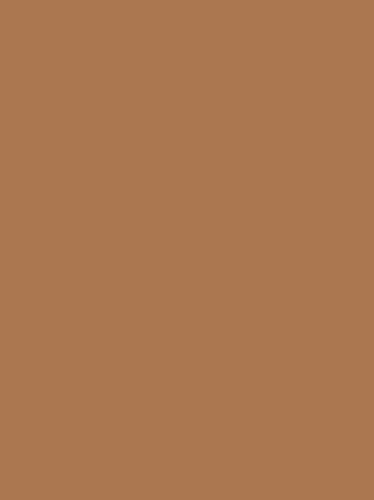

adaptive_thresh


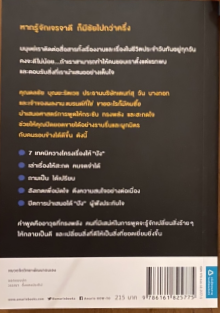

In [ ]:
for (i,j) in zip(detect_edged_houghlines,detect_edged_name_houghlines):
    print(j)
    if j == 'canny':
      warped_houghlines = four_point_transform(im, np.array(corner_houghlines(im,i,canny_minimun_vote)))
    else:
      warped_houghlines = four_point_transform(im, np.array(corner_houghlines(im,i,adaptive_thresh_minimun_vote)))
    cv2_imshow(warped_houghlines)

Reference 

Sr.Sorawit. Blog #3 : Python with OpenCV for Color Detection and find Corner Detection
medium [Internet]. 2018 Sep 30 [cited 2021 Oct 20]. 
Available from: https://medium.com/dolab/blog-3-python-with-opencv-for-color-detection-and-find
-corner-detection-4a4b4c77590b

tutorialspoint. OpenCV - Adaptive Threshold [Internet]. 2021 [cited 2021 Oct 20]. 
Available from: https://www.tutorialspoint.com/opencv/opencv_adaptive_threshold.htm 

Adrian Rosebrock. Pyimagesearch. How to Build a Kick-Ass Mobile Document Scanner in Just 5 Minutes [Internet]. 2014 Sep 1 [cited 2021 Oct 20]. 
Available from:https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner
-just-5-minutes/ 

Adrian Rosebrock. Pyimagesearch. 4 Point OpenCV getPerspective Transform Example [Internet]. 2014 Aug 25 [cited 2021 Oct 23]. 
Available from:https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform
-example/ 

alkasm. stack overflow. find intersection point of two lines drawn using houghlines opencv [Internet]. 2017 Oct 4 [cited 2021 Oct 23].
Available from: https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines
-drawn-using-houghlines-opencv

Devjyoti Chakraborty. Pyimagesearch. OpenCV Contour Approximation [Internet]. 2021 Oct 6 [cited 2021 Nov 3]. 
Available from: https://www.pyimagesearch.com/2021/10/06/opencv-contour-approximation/ 

Rebecca Stone. Real Python. Image Segmentation Using Color Spaces in OpenCV + Python [Internet]. 2018 [cited 2021 Nov 3].
Available from: https://realpython.com/python-opencv-color-spaces/

Johannes Schuck. Medium. Enhance a Document Scan using Python and OpenCV [Internet]. 2020 Jul 13 [cited 2021 Nov 3]. 
Available from: https://medium.com/analytics-vidhya/enhance-a-document-scan-using-python-and
-opencv-9934a0c2da3d 

Yasoob Khalid. yasoob. A guide to finding books in images using Python and OpenCV [Internet]. 2015 March 11 [cited 2021 Nov 3].
Available from: https://yasoob.me/2015/03/11/a-guide-to-finding-books-in-images-using-python
-and-opencv/

Opencv. Morphological Transformations [Internet]. [cited 2021 Nov 7].
Available from: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

OpenCV-Python Tutorials. Harris Cornor Detection[Internet]. 2016[cited 2021 Nov 7].
Available from: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py
_feature2d/py_features_harris/py_features_harris.html 